## Convolutional Neural Network For Recognition Of MNIST Handwritten Digit

Using Convolutional Neural Network(CNN) for predicting handwritten Digit Recognition

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import time
import tensorflow as tf
from datetime import timedelta
from sklearn.metrics import confusion_matrix

In [17]:
# Initial Configuration

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Load Data

    load MNIST Data to list

In [18]:
# filename for the dataset
filename_x_train = "train-images-idx3-ubyte.gz"
filename_y_train = "train-labels-idx1-ubyte.gz"
filename_x_test = "t10k-images-idx3-ubyte.gz"
filename_y_test = "t10k-labels-idx1-ubyte.gz"

# MNIST images are 28 pixels in each dimension.
img_size = 28

# Store the images in one-dimensional list of length:
img_size_flat = img_size * img_size

# The height and width of the image.
img_shape = (img_size, img_size)

# number of colour channels. 
num_channels = 1

# Tuple with height, width and depth
img_shape_full = (img_size, img_size, num_channels)

# Number of digit that will be recognized
num_classes = 10

In [19]:
# Data folder
data_dir = "../Handwritten_Recognition/MNIST/"

In [20]:
# Number of images in each subset
num_train = 55000
num_val = 5000
num_test = 10000

def _load_data(filename, offset):
        """
        Load the data in the given file. Automatically downloads the file
        if it does not already exist in the data_dir.

        :param filename: Name of the data-file.
        :param offset: Start offset in bytes when reading the data-file.
        :return: The data as a numpy array.
        """

        # Read the data-file.
        path = os.path.join(data_dir, filename)
        with gzip.open(path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=offset)

        return data

# Load the data
def _load_images(filename):
        """
        Load image-data from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """

        # Read the data as one long array of bytes.
        data = _load_data(filename=filename, offset=16)

        # Reshape to 2-dim array with shape (num_images, img_size_flat).
        images_flat = data.reshape(-1, img_size_flat)

        return images_flat
def _load_cls( filename):
        """
        Load class-numbers from the given file.
        Automatically downloads the file if it does not exist locally.

        :param filename: Name of the data-file.
        :return: Numpy array.
        """
        return _load_data(filename=filename, offset=8)
def random_batch(batch_size=32):
        """
        Create a random batch of training-data.

        :param batch_size: Number of images in the batch.
        :return: 3 numpy arrays (x, y, y_cls)
        """

        # Create a random index into the training-set.
        idx = np.random.randint(low=0, high=num_train, size=batch_size)

        # Use the index to lookup random training-data.
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        y_batch_cls = y_train_cls[idx]

        return x_batch, y_batch, y_batch_cls
# load training and validation data
x_train = _load_images(filename = filename_x_train)
y_train_cls = _load_cls(filename = filename_y_train)
# split the training set into train and validation
# convert pixel values into from ints b/n 0 and 255 to 0.0 and 1.0
x_train = x_train[0:num_train] / 255.0
x_val = x_train[num_train:] / 255.0
y_train_cls = y_train_cls[0:num_train]
y_val_cls = y_train_cls[num_train:]

# load test data
x_test = _load_images(filename=filename_x_test) / 255.0
y_test_cls = _load_cls(filename = filename_y_test)

# convert the class numbers from bytes to ints as that is needed for Tensorflow
y_train_cls = y_train_cls.astype(np.int)
y_val_cls = y_val_cls.astype(np.int)
y_test_cls = y_test_cls.astype(np.int)

# function for one hot encoding
def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.

    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]

    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.

    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.

    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

# Convert the integers class-numbers into one-hot encoded list.
y_train = one_hot_encoded(class_numbers = y_train_cls,
                         num_classes = num_classes)
y_val = one_hot_encoded(class_numbers = y_val_cls,
                       num_classes = num_classes)
y_test = one_hot_encoded(class_numbers = y_test_cls,
                        num_classes = num_classes)

In [21]:
print("Size of:")
print("- Training-set:\t\t{}".format(num_train))
print("- Validation-set:\t{}".format(num_val))
print("- Test-set:\t\t{}".format(num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [22]:
# function for ploting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

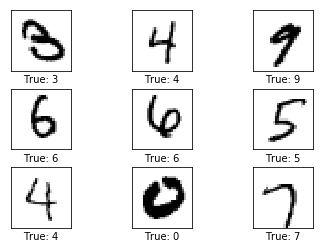

In [23]:
images = x_test[18:27]
cls_true = y_test_cls[18:27]
plot_images(images = images, cls_true=cls_true)

In [24]:
# Function Used to create new weights and bias
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [25]:
# Function used to create new convolutional layers by setting
# number of channels , filter_size etc.
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [26]:
# function for flatting layers
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [27]:
# Function for creating fully connected layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [28]:
# Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)



In [30]:
# Convolution layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size2,
                   num_filters=num_filters1,
                   use_pooling=True)

# Convolution layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)



In [31]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [32]:
# Fully connected Layer 
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [35]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
# Run Tensorflow
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64



In [51]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _ = random_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [58]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [59]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [60]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):


    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = x_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_test_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [47]:
print_test_accuracy()


Accuracy on Test-Set: 9.9% (994 / 10000)


In [54]:
optimize(num_iterations=1)

Time usage: 0:00:00


In [55]:
print_test_accuracy()

Accuracy on Test-Set: 10.0% (998 / 10000)


In [56]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Optimization Iteration:    101, Training Accuracy:  79.7%
Time usage: 0:00:09


Accuracy on Test-Set: 71.1% (7107 / 10000)
Example errors:


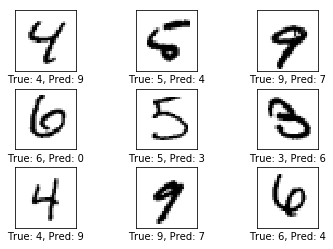

In [61]:
print_test_accuracy(show_example_errors=True)

In [62]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    201, Training Accuracy:  79.7%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  93.8%
Optimization Iteration:    501, Training Accuracy:  95.3%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  89.1%
Optimization Iteration:   1001, Training Accuracy:  96.9%
Time usage: 0:01:22


Accuracy on Test-Set: 93.4% (9339 / 10000)
Example errors:


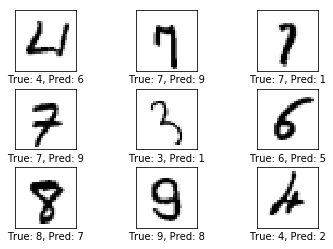

In [64]:
print_test_accuracy(show_example_errors=True)

In [65]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  92.2%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization Iteration:   2701, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.6% (9859 / 10000)
Example errors:


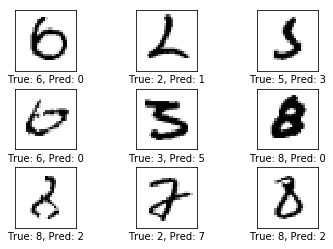

Confusion Matrix:
[[ 974    0    1    0    0    1    1    1    2    0]
 [   0 1127    3    0    0    0    1    1    3    0]
 [   3    1 1018    0    1    0    0    3    6    0]
 [   0    0    0  998    0    6    0    2    2    2]
 [   1    0    0    0  977    0    1    1    0    2]
 [   2    0    0    3    0  883    3    1    0    0]
 [   6    2    0    1    2    3  944    0    0    0]
 [   0    1    5    0    0    0    0 1020    1    1]
 [   5    0    5    2    2    5    1    6  946    2]
 [   4    5    2    1   10    8    0    5    2  972]]


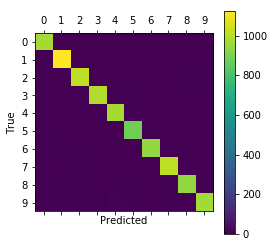

In [66]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

In [67]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [68]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [69]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

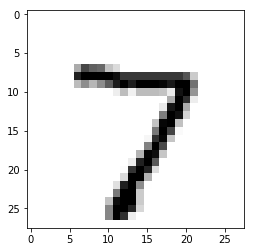

In [70]:
image1 = x_test[0]
plot_image(image1)

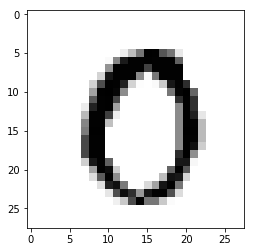

In [71]:
image2 = x_test[13]
plot_image(image2)

In [72]:
plot_conv_weights(weights=weights_conv1)

NameError: name 'math' is not defined

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image1)

In [ ]:
plot_conv_layer(layer=layer_conv1, image=image2)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [ ]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [ ]:
# Session.run